# Intel Image Classification using PyTorch

This Notebook is about building a powerful Neural networks that can classify Natural Scenes around the world. The Dataset is from **Intel Image classification challenge**

The goal is classify the images under the 6 caregories '**Buildings**', '**Forest**', '**Glacier**', '**mountain**', '**Sea**', '**Street**'.

In this notebook I have compared the performance 3 Models : **Feed forward neural network**, **Convolutional neural network**  and **Resnet34**. 

### Import libraries

In [3]:
import os 
import torch  
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score 
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

%matplotlib inline

### Preparing Dataset

In [4]:
train_dataset_dir = '../input/intel-image-classification/seg_train/seg_train'
test_dataset_dir = '../input/intel-image-classification/seg_test/seg_test'

dataset_dir = ['../input/intel-image-classification/seg_train/seg_train',
               '../input/intel-image-classification/seg_test/seg_test']

Making a dictionary of labels which will be helpful to make label column in dataframe

In [66]:
label_list=['buildings','forest','glacier','mountain','sea','street']

labels = {label_list:i for i,label_list in enumerate(label_list)}
labels

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

We will make a dataframe of image name and its label then store it in csv file.

In [6]:

def create_dataset(dataset_path,labels,file_name):
    labelled_arr=np.array([])
    for subdir, label in labels.items():
        img_dir = os.path.join(dataset_path, subdir) 
        files = np.array(os.listdir(img_dir)).reshape(-1,1) 
        target = np.array([label for i in range(files.shape[0])]).reshape(-1,1) 
        data = np.concatenate((files, target), axis = 1) 
        labelled_arr = np.append(labelled_arr, data)
    labelled_arr = labelled_arr.reshape(-1,2)

    dataframe = pd.DataFrame(labelled_arr)
    dataframe.columns = ['image', 'label']
    dataframe['label'] = dataframe['label'].astype('int')
    print (dataframe.head())
    print (file_name)
    dataframe.to_csv(file_name, index = False)
    return dataframe
    

In [7]:
train_df = create_dataset(train_dataset_dir,labels,'./train.csv')
test_df = create_dataset(test_dataset_dir, labels,'./test.csv')

       image  label
0    230.jpg      0
1   1220.jpg      0
2  17272.jpg      0
3  11345.jpg      0
4   6673.jpg      0
./train.csv
       image  label
0  21182.jpg      0
1  24229.jpg      0
2  21141.jpg      0
3  21011.jpg      0
4  20922.jpg      0
./test.csv


Making the class to create dataset. This class will transform the dataset using given transformers

In [8]:
class IntelImageDataset(Dataset):
    def __init__(self, dataframe, data_dir, label_dict, transform = None):
        self.df = dataframe
        self.data_dir = data_dir
        self.label_dict = label_dict
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name, label = self.df.loc[idx]
        class_labels = list(self.label_dict.keys())
        img_path = self.data_dir + '/' + class_labels[label] + '/' + img_name
        img = img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label 

As images are in dataset are of different shape using Resize transformer to resize all images into one shape also converting this images into tensors using ToTensor()


In [9]:
train_tfms = T.Compose([
    T.Resize([256,256]),
    T.ToTensor()
#     T.RandomErasing()
])

test_tfms = T.Compose([
    T.Resize([256, 256]),
    T.ToTensor(),
])

Creating traning and test dataset using IntelImageDataset class

In [10]:
train_ds = IntelImageDataset(train_df, train_dataset_dir, labels, transform = train_tfms)


test_ds = IntelImageDataset(test_df, test_dataset_dir, labels, transform = test_tfms)

### Exploring the Data

In [11]:
len(train_ds), len(test_ds)

(14034, 3000)

In [12]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)

Labels: 5


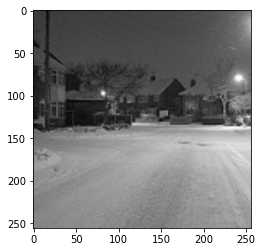

In [13]:
show_sample(*train_ds[14000],invert=False)

### Training and validation dataset

Splitting datset into 3 parts 

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In [14]:
val_size = 4000
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

(10034, 4000)

Creating DataLoaders for Training and Valiadation sets in batches

In [15]:
batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, 
                    num_workers=2, pin_memory=True)

In [16]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [17]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    print (labels)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([32, 3, 256, 256])
tensor([1, 5, 5, 2, 3, 2, 2, 1, 3, 5, 4, 0, 3, 2, 2, 4, 1, 0, 0, 5, 1, 3, 0, 4,
        4, 2, 2, 5, 2, 3, 2, 3])
out.shape: torch.Size([32, 8, 128, 128])


Defining a function to look Images in batches using make_grid method from torchvision.

In [18]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=8).permute(1, 2, 0))
        break

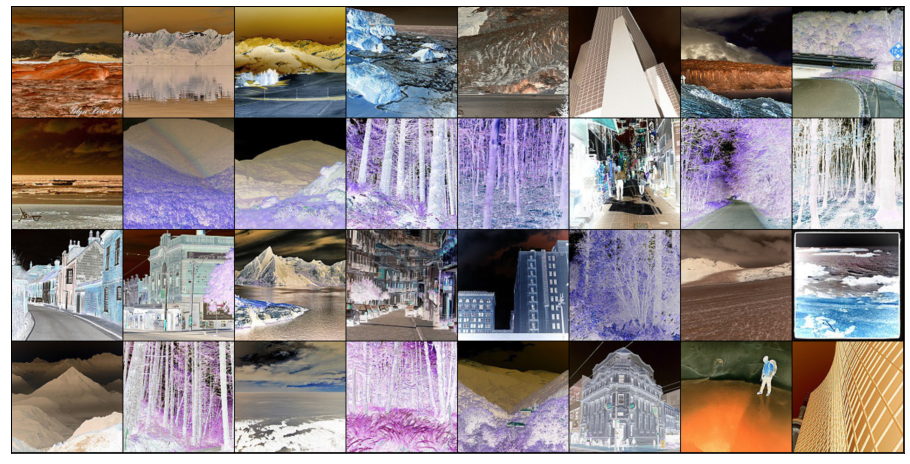

In [19]:
show_batch(train_dl, invert=True)

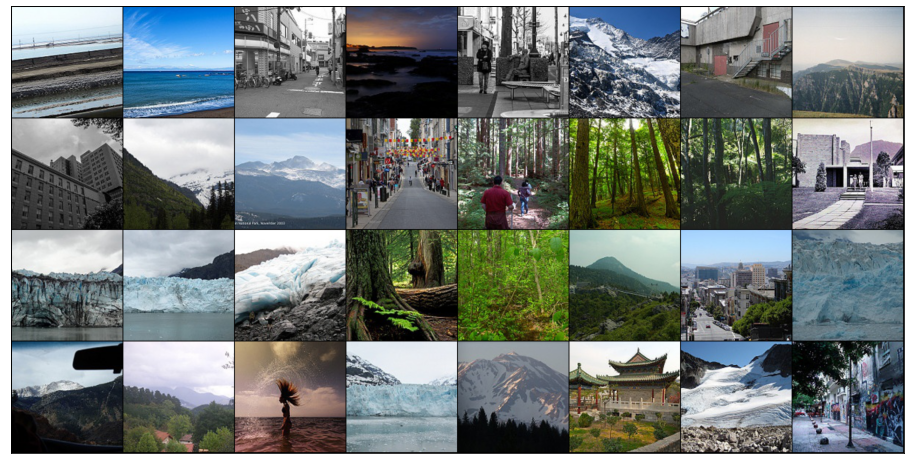

In [20]:
show_batch(train_dl, invert=False)

To use a GPU, we have defined a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available), and use to_device to move our model to the GPU 

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

Defining accuracy function to get the accuracy

In [90]:

def accuracy(outputs, target):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == target).item() / len(preds))

Creating a class IntelImageClassificationBase() which contain helper methods for training ad validation

In [34]:
class IntelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

Defining a evaluate function which willperform validation phase and fir function which will perform training process

In [40]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Simple Feed Forward Neural Network

Lets define a simple feed forward neural network model FNNModel() by extending a IntelImageClassificationBase() classwhich contains helper methods

creating model with 4 hidden leayers and ReLu activation 

In [35]:
class FNNModel(IntelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # hidden layer1
        self.linear1 = nn.Linear(3*256*256, 512)
        # hidden layer2
        self.linear2 = nn.Linear(512,256)
        # hidden layer3
        self.linear3 = nn.Linear(256,128)
        # hidden layer4
        self.linear4 = nn.Linear(128,64)
        # output layer
        self.linear5 = nn.Linear(64, 6)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        
        # Get intermediate outputs using hidden layer1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        
        # Get intermediate outputs using hidden layer2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        
        # Get intermediate outputs using hidden layer3
        out = self.linear3(out)
        # Apply activation function
        out = F.relu(out)
        
        # Get intermediate outputs using hidden layer4
        out = self.linear4(out)
        # Apply activation function
        out = F.relu(out)
        
        
        # Get predictions using output layer
        out = self.linear5(out)
        return out

In [36]:
model = FNNModel()
model

FNNModel(
  (linear1): Linear(in_features=196608, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=6, bias=True)
)

moving model to GPU

In [38]:
model = to_device(model,device)

In [91]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print (labels)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 256, 256])
tensor([0, 2, 1, 1, 1, 1, 3, 2, 3, 0, 0, 5, 3, 0, 2, 3, 1, 3, 4, 0, 5, 3, 0, 0,
        0, 4, 5, 4, 1, 4, 3, 3], device='cuda:0')
out.shape: torch.Size([32, 6])
out[0]: tensor([ 0.0762,  0.6376, -0.4209, -1.4992,  0.1238,  0.1122], device='cuda:0',
       grad_fn=<SelectBackward>)


lets get the initial accuracy of the model before traning

In [42]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.7962151765823364, 'val_score': 0.1692499965429306}]

Train the model using hyperparameters epchs, learning rate

In [43]:
history += fit(10, 0.001, model, train_dl, val_dl)

Epoch [0], train_loss: 1.7826, val_loss: 1.7728, val_score: 0.2115
Epoch [1], train_loss: 1.7545, val_loss: 1.7403, val_score: 0.2645
Epoch [2], train_loss: 1.7137, val_loss: 1.6925, val_score: 0.3298
Epoch [3], train_loss: 1.6560, val_loss: 1.6276, val_score: 0.3365
Epoch [4], train_loss: 1.5823, val_loss: 1.5548, val_score: 0.3458
Epoch [5], train_loss: 1.5057, val_loss: 1.4796, val_score: 0.4338
Epoch [6], train_loss: 1.4441, val_loss: 1.4312, val_score: 0.4658
Epoch [7], train_loss: 1.3993, val_loss: 1.3867, val_score: 0.4765
Epoch [8], train_loss: 1.3637, val_loss: 1.3606, val_score: 0.4785
Epoch [9], train_loss: 1.3357, val_loss: 1.3326, val_score: 0.4997


So after 10 epochs we are getting accuracy around 50% for simple feed forward neural network.

lets plot the accuracy of validation dataset to see howmodel improves over time

In [44]:
def plot_accuracies(history):
#     print(history)
    accuracies = [x['val_score'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

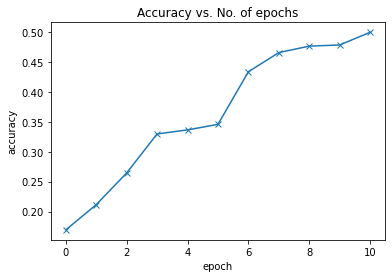

In [45]:
plot_accuracies(history)

Lets plot the training losses and validation losses to see if the model is overfitting or not.

In [46]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

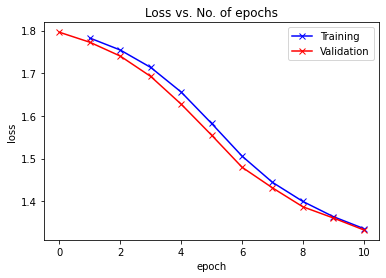

In [48]:
plot_losses(history)

### Testing with Individual images

Lets define a function which predict label for a single image

In [49]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return label_list[preds[0].item()]

0
Label: buildings , Predicted: mountain


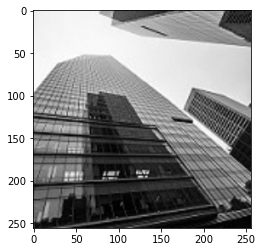

In [50]:
img,label = test_ds[0]
print (label)
plt.imshow(img.permute(1, 2, 0))
print('Label:', label_list[label], ', Predicted:', predict_image(img, model))

0
Label: buildings , Predicted: glacier


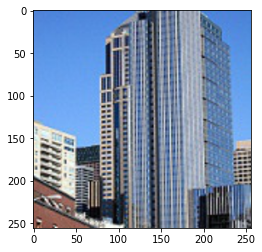

In [51]:
img,label = test_ds[10]
print (label)
plt.imshow(img.permute(1, 2, 0))
print('Label:', label_list[label], ', Predicted:', predict_image(img, model))

So from feed forward neural network model we are getting accuracy of 50% also model could not able predict the given images correctly.

To improve the accuarcy we can train the model with higher epochs and different learning rates

### Convolutional Neural Network

Lets define Convolutional neural network CnnModel() by extending a IntelImageClassificationBase()

Using Sequential() to chain the layers and activations functions into a single network architecture.

In [52]:
class CnnModel(IntelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 128 x 128

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 64 x 64

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 32 x 32

            nn.Flatten(), 
            nn.Linear(256*32*32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6))
        
    def forward(self, xb):
        return self.network(xb)

In [53]:
model1 = CnnModel()
model1

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=262144, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features=512,

In [54]:
model1 = to_device(CnnModel(), device)

In [55]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model1(images)
    print (labels)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 256, 256])
tensor([3, 2, 1, 2, 5, 1, 2, 2, 3, 4, 4, 5, 1, 4, 2, 2, 0, 4, 5, 2, 5, 0, 4, 2,
        3, 0, 0, 4, 2, 1, 4, 2], device='cuda:0')
out.shape: torch.Size([32, 6])
out[0]: tensor([-0.0325,  0.0012,  0.0328,  0.0357,  0.0203, -0.0066], device='cuda:0',
       grad_fn=<SelectBackward>)


In [56]:
evaluate(model1, val_dl)

{'val_loss': 1.791641354560852, 'val_score': 0.1717499941587448}

Define the hyperparameters to train the model

In [57]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 1e-4

Lets train the CNN model with given hyperparameter

In [58]:
%%time
history1 = fit(num_epochs, lr, model1, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1289, val_loss: 0.9907, val_score: 0.6140
Epoch [1], train_loss: 0.8608, val_loss: 0.8075, val_score: 0.6845
Epoch [2], train_loss: 0.6974, val_loss: 0.6996, val_score: 0.7303
Epoch [3], train_loss: 0.5737, val_loss: 0.6402, val_score: 0.7607
Epoch [4], train_loss: 0.4619, val_loss: 0.6455, val_score: 0.7648
Epoch [5], train_loss: 0.3180, val_loss: 0.7218, val_score: 0.7570
Epoch [6], train_loss: 0.1962, val_loss: 0.8937, val_score: 0.7580
Epoch [7], train_loss: 0.1255, val_loss: 1.0538, val_score: 0.7645
Epoch [8], train_loss: 0.0853, val_loss: 1.0588, val_score: 0.7765
Epoch [9], train_loss: 0.0451, val_loss: 1.3228, val_score: 0.7613
CPU times: user 7min 34s, sys: 5min 42s, total: 13min 16s
Wall time: 16min 57s


After 10 epochs we are getting accuracy around 76%.

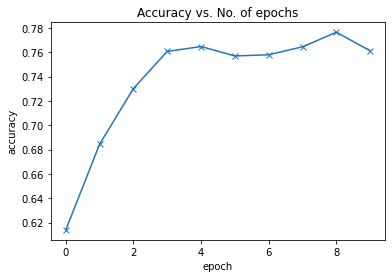

In [59]:
plot_accuracies(history1)

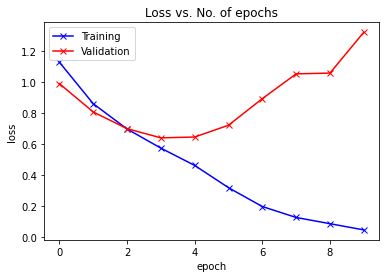

In [60]:
plot_losses(history1)

Initialy, both the training and validation loss decreasing but after certain point training loss continues to decrease while the validation loss stops decreasing and start to increase instead. This is the example of **Overfittng**.

0
Label: buildings , Predicted: buildings


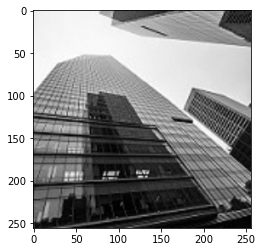

In [61]:
img,label = test_ds[0]
print (label)
plt.imshow(img.permute(1, 2, 0))
print('Label:', label_list[label], ', Predicted:', predict_image(img, model1))

0
Label: buildings , Predicted: buildings


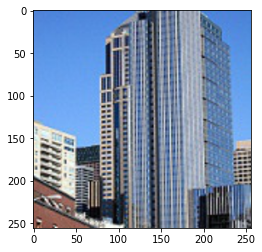

In [62]:
img,label = test_ds[10]
print (label)
plt.imshow(img.permute(1, 2, 0))
print('Label:', label_list[label], ', Predicted:', predict_image(img, model1))

So from Convolutional neural network model we are getting accuracy of 76% also model could able predict the given images correctly. But model is overfitted.

## **ResNet & Regularization**

### Data Augmentation

There are a few important changes we'll make while creating the datasets:

I am using few tranform functions to transform the dataset
Resize() = Resize the input Image to the given size.
RandomHorizontalFlip() = Horizontally flip the given image randomly.
RandomRotation() = Rotate Image by given angle
RandomErasing() = Randomly selects a rectangle region in an image and erases its pixels

In [68]:

train_tfms = T.Compose([
    T.Resize([256,256]),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.ToTensor(), 
    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
    T.Resize([256,256]), 
    T.ToTensor(),
])

Creating dataset using transformations

In [69]:
train_ds2 = IntelImageDataset(train_df, train_dataset_dir, labels, transform = train_tfms)


test_ds2 = IntelImageDataset(test_df, test_dataset_dir, labels, transform = test_tfms)

Lets see the images after transformation

Labels: 5


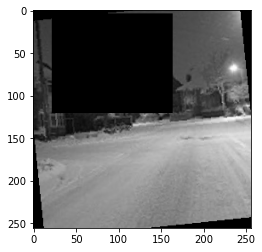

In [70]:
show_sample(*train_ds2[14000],invert=False)

Labels: 5


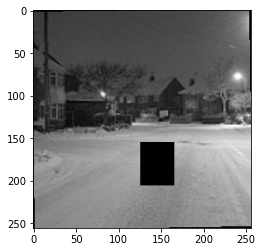

In [71]:
show_sample(*train_ds2[14000],invert=False)

In [72]:
val_size = 4000
train_size = len(train_ds2) - val_size

train_ds2, val_ds2 = random_split(train_ds2, [train_size, val_size])
len(train_ds2), len(val_ds2)

(10034, 4000)

In [73]:
batch_size = 32

In [74]:
train_dl2 = DataLoader(train_ds2, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl2 = DataLoader(val_ds2, batch_size*2, 
                    num_workers=2, pin_memory=True)

Lets see thebatches of images after data augmentation

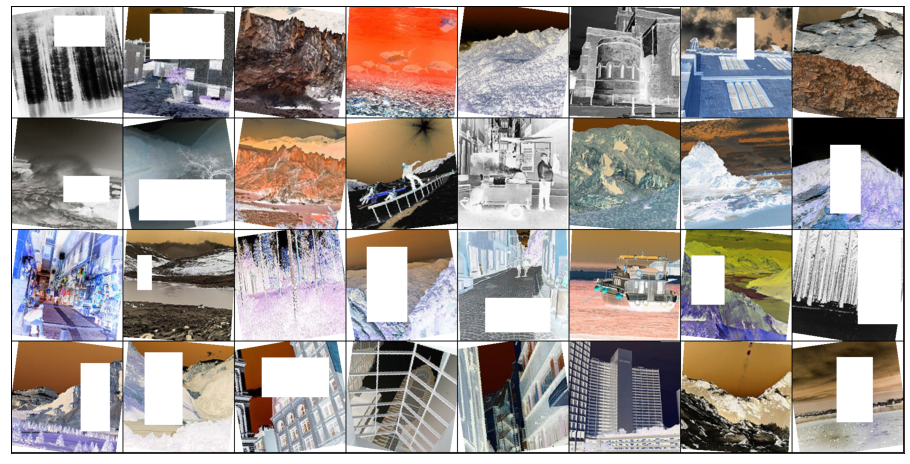

In [75]:
show_batch(train_dl2, invert=True)

Here I am using pretrained ResNet34 Model to train this dataset

In [76]:
class IntelImageResnet(IntelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 6)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [77]:
train_dl2 = DeviceDataLoader(train_dl2, device)
val_dl2 = DeviceDataLoader(val_dl2, device)
to_device(model, device);

### Improving Fit function

1. Learning rate scheduling = One Cycle Learning Rate Policy which start with lower learning rate, gradualy start increasing it batch by batch to the given high learning rate for about 30% of the epochs and then gradually decreasing to the lower value forthe remaining epochs

2. Weight decay: Regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function

4. Gradient clipping: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.

In [78]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [79]:
model2 = to_device(IntelImageResnet(), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [80]:
history2 = [evaluate(model2, val_dl2)]
history2

[{'val_loss': 1.8161375522613525, 'val_score': 0.0972222238779068}]

Lets first train the model on the final layer which means we will not change the parameters of layers except final layer

In [81]:
model2.freeze()

In [82]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

In [83]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl2, val_dl2, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 1.3864, val_loss: 1.1478, val_score: 0.9060



Epoch [1], train_loss: 1.1415, val_loss: 1.1192, val_score: 0.9164



Epoch [2], train_loss: 1.1170, val_loss: 1.1188, val_score: 0.9125



Epoch [3], train_loss: 1.1108, val_loss: 1.1133, val_score: 0.9211



Epoch [4], train_loss: 1.1055, val_loss: 1.1027, val_score: 0.9298



Epoch [5], train_loss: 1.0952, val_loss: 1.1029, val_score: 0.9318



Epoch [6], train_loss: 1.0943, val_loss: 1.1014, val_score: 0.9281



Epoch [7], train_loss: 1.0884, val_loss: 1.1007, val_score: 0.9330



Epoch [8], train_loss: 1.0824, val_loss: 1.0980, val_score: 0.9382



Epoch [9], train_loss: 1.0789, val_loss: 1.0964, val_score: 0.9415
CPU times: user 3min 6s, sys: 55.5 s, total: 4min 2s
Wall time: 10min 4s


Now lets unfreeze all the layers

In [84]:
model2.unfreeze()

In [85]:
%%time
history2 += fit_one_cycle(epochs, 0.01, model2, train_dl2, val_dl2, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 1.0780, val_loss: 1.1029, val_score: 0.9335



Epoch [1], train_loss: 1.0853, val_loss: 1.1060, val_score: 0.9258



Epoch [2], train_loss: 1.0843, val_loss: 1.1067, val_score: 0.9273



Epoch [3], train_loss: 1.0841, val_loss: 1.1020, val_score: 0.9330



Epoch [4], train_loss: 1.0813, val_loss: 1.1000, val_score: 0.9303



Epoch [5], train_loss: 1.0763, val_loss: 1.0982, val_score: 0.9390



Epoch [6], train_loss: 1.0740, val_loss: 1.0994, val_score: 0.9363



Epoch [7], train_loss: 1.0700, val_loss: 1.1001, val_score: 0.9318



Epoch [8], train_loss: 1.0663, val_loss: 1.0943, val_score: 0.9410



Epoch [9], train_loss: 1.0632, val_loss: 1.0979, val_score: 0.9368
CPU times: user 3min 10s, sys: 54.6 s, total: 4min 5s
Wall time: 10min 34s


We are getting 94% of accuracy

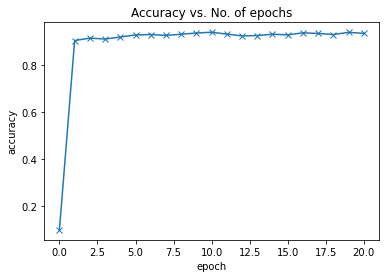

In [86]:
plot_accuracies(history2)

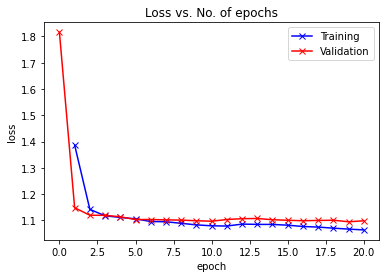

In [87]:
plot_losses(history2)

Both the training loss and validation loss decreaseing gradualy so there is caseof overfitting

0
Label: buildings , Predicted: buildings


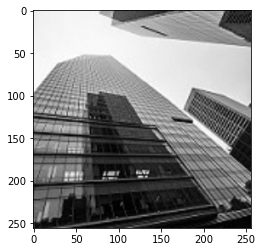

In [88]:
img,label = test_ds[0]
print (label)
plt.imshow(img.permute(1, 2, 0))
print('Label:', label_list[label], ', Predicted:', predict_image(img, model2))

0
Label: buildings , Predicted: buildings


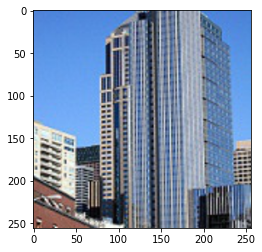

In [89]:
img,label = test_ds[10]
print (label)
plt.imshow(img.permute(1, 2, 0))
print('Label:', label_list[label], ', Predicted:', predict_image(img, model2))

# **Summary**

Here's a summary the different topics and models covered in this notebook


1. Downloading, Extracting and  Creating a dataset using torchvision
2. Show randombatched of images using make_grid function
3. Creating a simple feed forward neural network with hidden layer
4. Creating a Convolutional neural network
5. ResNet and Data augmentation
6. Training the models and Visualizing accuracies and losees
7. Generating a predictions on single images
8. ResNet model with (94%) accuracy out perform CNN (76%) and feedforward neurl network(49%)models 